In [2]:
import gym
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

colors = ["#9d6d00", "#903ee0", "#11dc79", "#f568ff", "#419500", "#013fb0", 
          "#f2b64c", "#007ae4", "#ff905a", "#33d3e3", "#9e003a", "#019085", 
          "#950065", "#afc98f", "#ff9bfa", "#83221d", "#01668a", "#ff7c7c", 
          "#643561", "#75608a"]

# Laboratorio 1

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## The Cliff


![](images/cliffwalking.png)

El problema consiste en que el agente aprenda a ir desde el punto de salida (S) hasta el punto de llegada (G), sin caer en el acantilado. Al caer en el acantilado el agente vuelve al estado inicial en un mismo episodio.

### Acciones

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

### Función de recompensa

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

# SARSA

El metodo `sarsa_learning` implementa el ciclo de aprendizaje. Devuelve la cantidad de pasos por episodio y la recompensa por episodio.

In [3]:
def sarsa_learning(q, alpha, gamma, epsilon, episodes_to_run):
    """
    Run SARSA learning algorithm
    """

    timesteps_of_episode = []
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        action = choose_action(state, q, epsilon)        
        while not done:
            next_state, reward, done, info = env.step(action)
            episode_reward += reward            
            next_action = choose_action(next_state, q, epsilon)
            
            if not done and t < 2000: 
                sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma)
                state = next_state
                action = next_action
            else:
                done = True 
                sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma) 
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return timesteps_of_episode, reward_of_episode

El método `choose_action` implementa la política de exploración $\epsilon$-greedy. Elige la mejor acción posible en el estado `state` de acuerdo a la tabla `q`, pero con problabilidad `epsilon` escoge una acción arbitraria.

In [4]:
def choose_action(state, q, epsilon):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)

    count = q_values.count(max_q)
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

El núcleo de SARSA es la actualización de la función `q` de acuerdo a la siguiente ecuación:

                q(s, a) = q(s, a) + alpha * [R + gamma * q(s', a') - q(s, a)]

In [5]:
def sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma):
    """
    Performs a SARSA update for a given state transition
    """
    current_q = q.get((state,action), 0.0)
    next_q = q.get((next_state,next_action), 0.0)
    q[(state,action)] = current_q + alpha * (reward + gamma * next_q - current_q)

## Búsqueda de hiperparámetros

Implementamos una búsqueda de hiperparámetros `alpha` y `gamma` para evaluar su impacto en la convergencia SARSA. Mas adelante analizamos el impacto del hiperparámetro `epsilon`.

In [12]:
s_timesteps = {}
s_rewards = {} 

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
episodes_to_run = 500
epsilon = 0.1

for alpha in [0.2, 0.4, 0.6, 0.8]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1.0]:
        q_i = {}
        random_state = np.random.RandomState(42)
        timesteps_i, reward_i = sarsa_learning(q_i, alpha, gamma, epsilon, episodes_to_run)

        name = "SARSA-alpha:%.2f-gamma:%.2f" % (alpha, gamma)
        s_timesteps[name] = timesteps_i
        s_rewards[name] = reward_i
env.close()

Text(0.5, 0, 'Episodio')

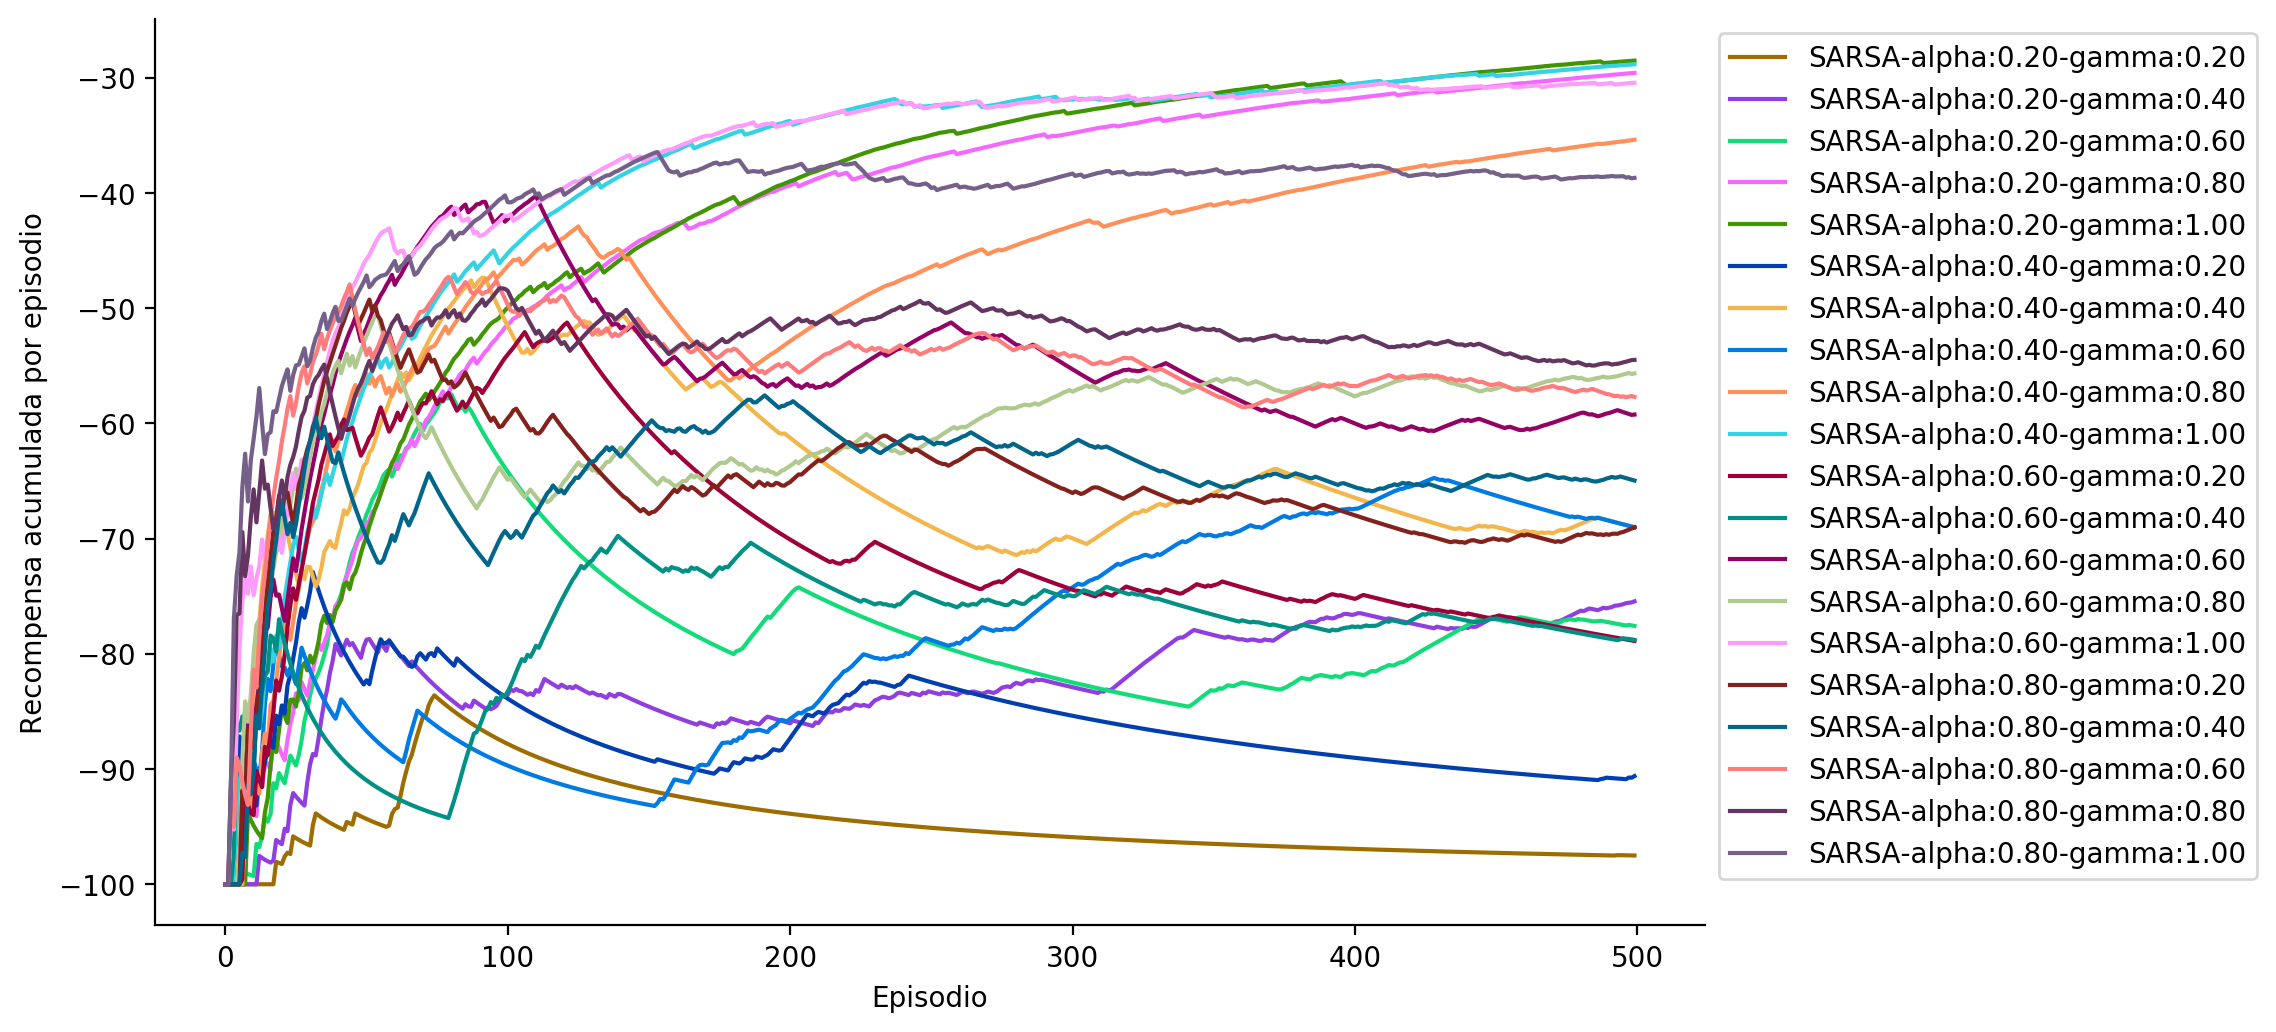

In [13]:
plt.figure(figsize=(10,6), dpi=200)
df = pd.DataFrame(s_rewards)
sns.lineplot(data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors)
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")

Podemos observar que cuanto mas grande `gamma`, mejores valores de recompensa se obtienen. Esto no resulta sorprendente ya que por la forma en que está diseñada la recompensa, la posibilidad de caerse en el acantilado en el futuro es determinante.

Para apreciar el impacto de la variación de `alpha`, vemos en detalle qué sucede cuando `gamma` igual a 1.00.

Text(0.5, 0, 'Episodio')

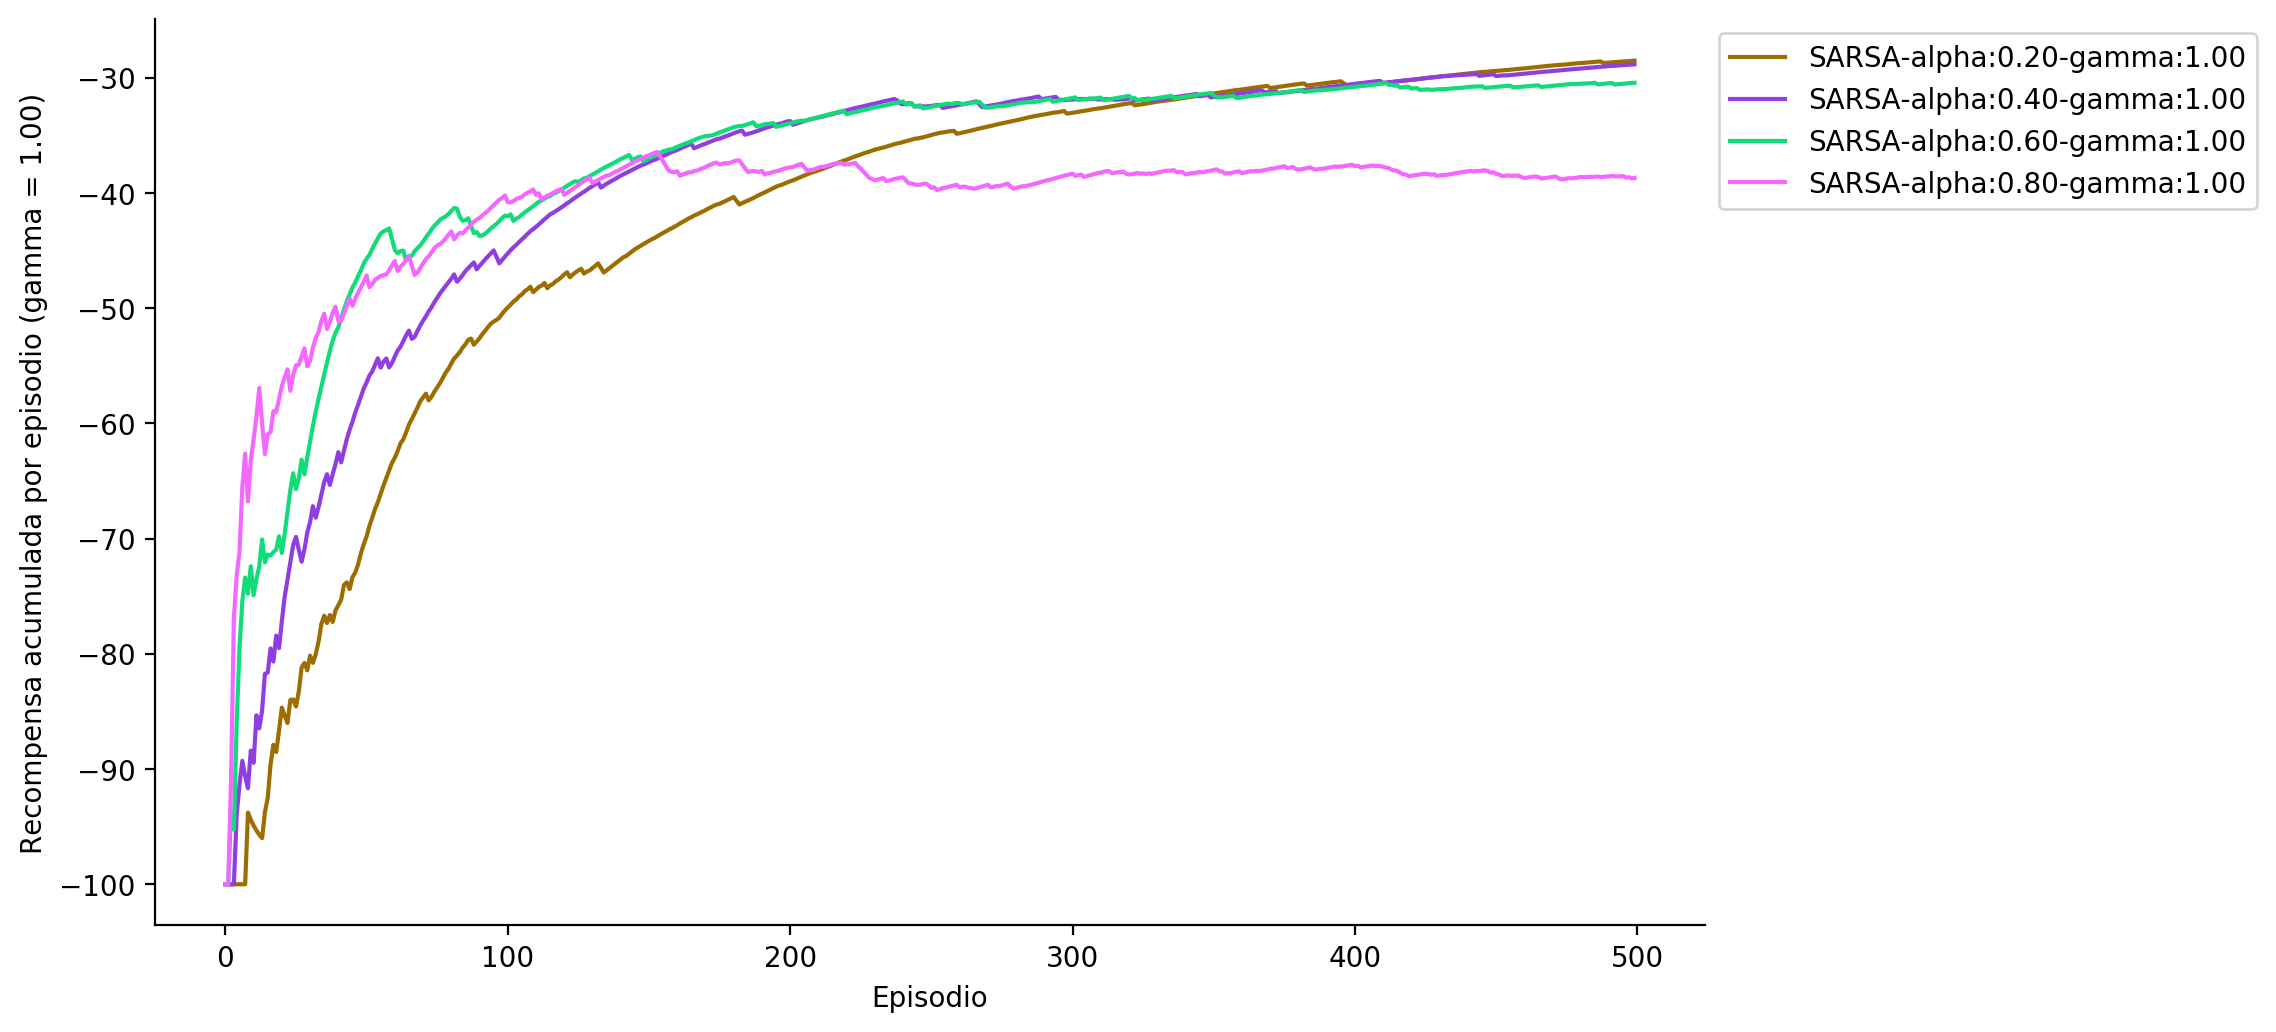

In [17]:
gamma_rewards = {k:v for k,v in s_rewards.items() if "gamma:1.00" in k}
plt.figure(figsize=(10,6), dpi=200)
df = pd.DataFrame(gamma_rewards)
sns.lineplot(data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors[:4])
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio (gamma = 1.00)")
plt.xlabel("Episodio")

Como es de esperar, valores pequeños de `alpha` hacen que el aprendizaje sea mas lento pero mas estable. Los valores 0.20 y 0.40 obtienen prácticamente el mismo desempeño. Los valores mayores hacen el aprendizaje sea mas rápido al inicio pero mas inestable a largo plazo.

(20, 60)

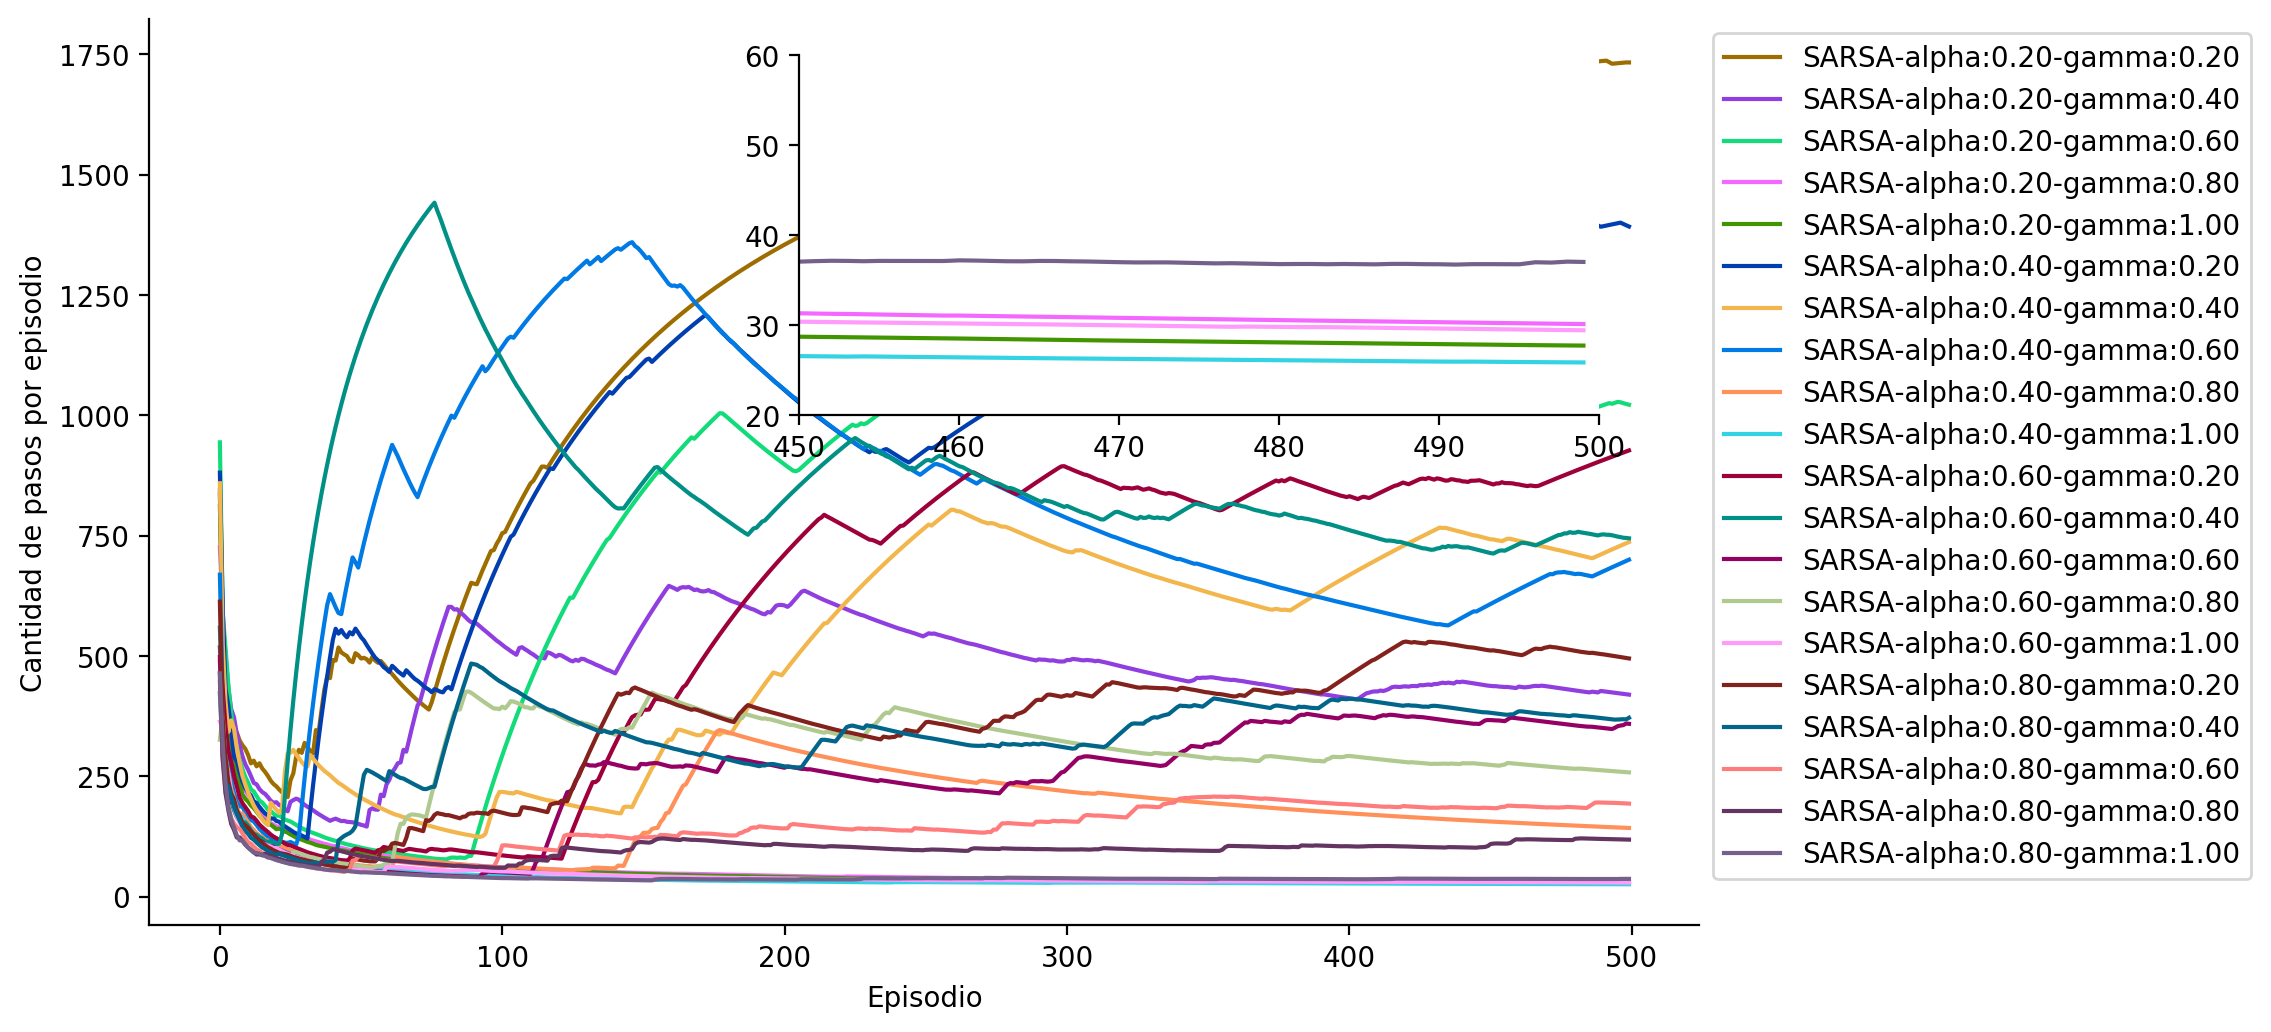

In [19]:
plt.figure(figsize=(10,6), dpi=200)
ax1 = plt.axes()  # standard axes
ax2 = plt.axes([0.45, 0.55, 0.4, 0.3])
df = pd.DataFrame(s_timesteps)
s = sns.lineplot(ax=ax1, data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors)
sns.despine()
s.legend(bbox_to_anchor=(1.0, 1))
s.set_ylabel("Cantidad de pasos por episodio")
s.set_xlabel("Episodio")
s2 = sns.lineplot(ax=ax2, data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors,legend=False)
s2.set_xlim(450,500)
s2.set_ylim(20,60)

Lo dicho anteriormente aplica también cuando observamos el desempeño de la cantidad de pasos. En función de ello, escojemos los siguientes hiperparámetros:

- `alpha` = 0.5
- `gamma` = 1.0

# Q-learning

El metodo `q_learning` implementa el ciclo de aprendizaje. Difiere ligeramente de SARSA en la forma en que calcula la próxima acción. Devuelve la cantidad de pasos por episodio y la recompensa por episodio.

In [6]:
def q_learning(q, alpha, gamma, epsilon, episodes_to_run):
    """
    Run Q learning algorithm
    """

    timesteps_of_episode = []
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        while not done:
            action = choose_action(state, q, epsilon)
            next_state, reward, done, info = env.step(action)         

            episode_reward += reward

            if not done and t < 2000: 
                qlearning_learn(state, action, reward, next_state, q, alpha, gamma)
                state = next_state
            else:
                done = True 
                qlearning_learn(state, action, reward, next_state, q, alpha, gamma)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return timesteps_of_episode, reward_of_episode

El núcleo de Q-learning es la actualización de la función `q` de acuerdo a la siguiente ecuación:

                q(s, a) = q(s, a) + alpha * [R + gamma * max(q(s', a')) - q(s, a)]

In [7]:
def qlearning_learn(state, action, reward, next_state, q, alpha, gamma):
    """
    Performs a Q-learning update for a given state transition
    """
    current_q = q.get((state,action), 0.0)
    
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_values)   
    
    q[(state,action)] = current_q + alpha * (reward + gamma * max_q - current_q)

## Búsqueda de hiperparámetros

Implementamos una búsqueda de hiperparámetros `alpha` y `gamma` para evaluar su impacto en la convergencia Q-learning. Mas adelante analizamos el impacto del hiperparámetro `epsilon`.

In [8]:
q_timesteps = {}
q_rewards = {} 

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
episodes_to_run = 500
epsilon = 0.1

for alpha in [0.2, 0.4, 0.6, 0.8]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1.0]:
        q_i = {}
        random_state = np.random.RandomState(42)
        timesteps_i, reward_i = q_learning(q_i, alpha, gamma, epsilon, episodes_to_run)

        name = "Q-learning-alpha:%.2f-gamma:%.2f" % (alpha, gamma)
        q_timesteps[name] = timesteps_i
        q_rewards[name] = reward_i
env.close()

(-42, -36)

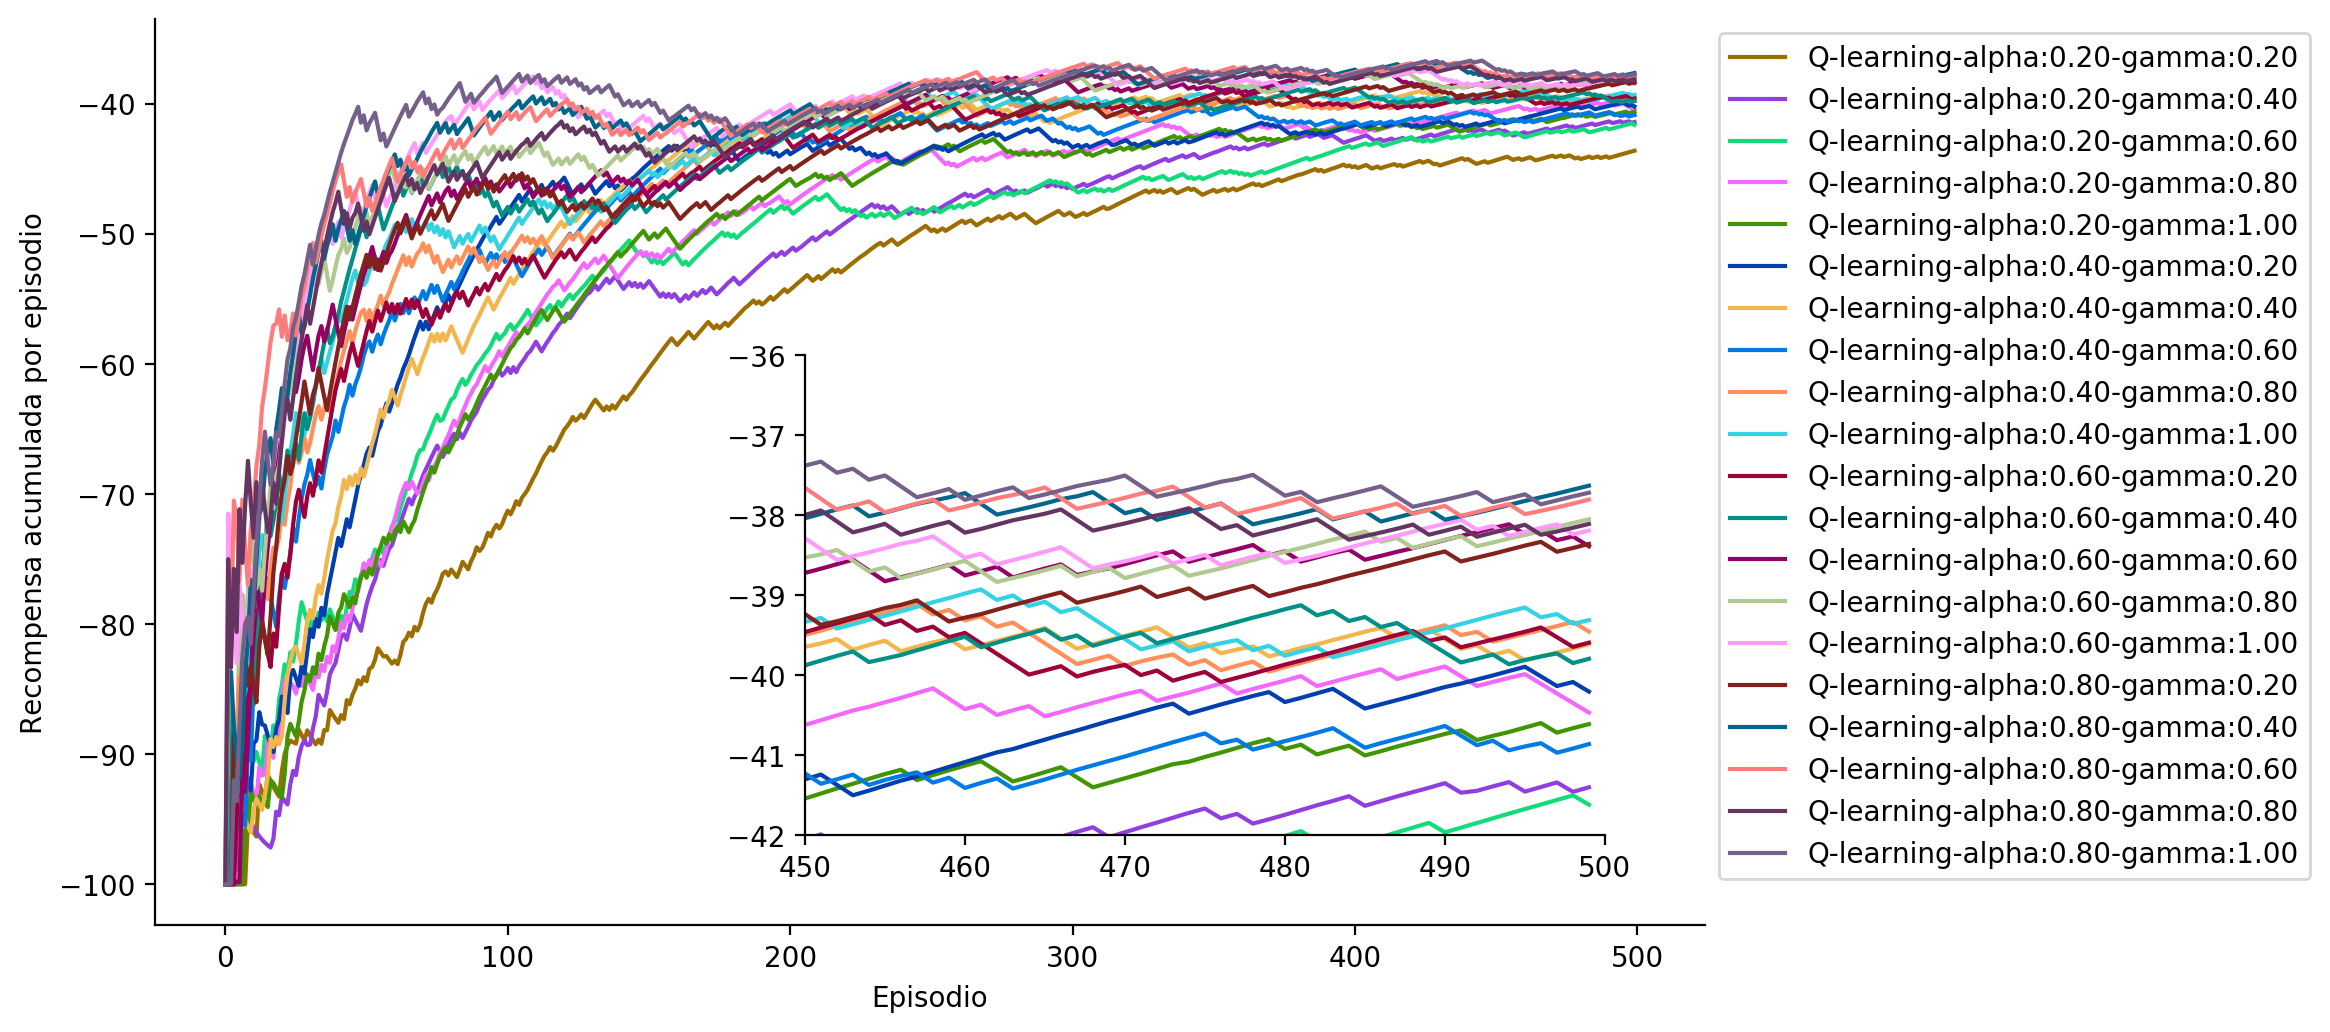

In [13]:
plt.figure(figsize=(10,6),dpi=200)
ax1 = plt.axes()  # standard axes
ax2 = plt.axes([0.45, 0.20, 0.4, 0.4])
df = pd.DataFrame(q_rewards)
s = sns.lineplot(ax=ax1,data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors)
sns.despine()
s.legend(bbox_to_anchor=(1.0, 1))
s.set_ylabel("Recompensa acumulada por episodio")
s.set_xlabel("Episodio")
s2 = sns.lineplot(ax=ax2,data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors,legend=False)
s2.set_xlim(450,500)
s2.set_ylim(-42,-36)

(18, 25)

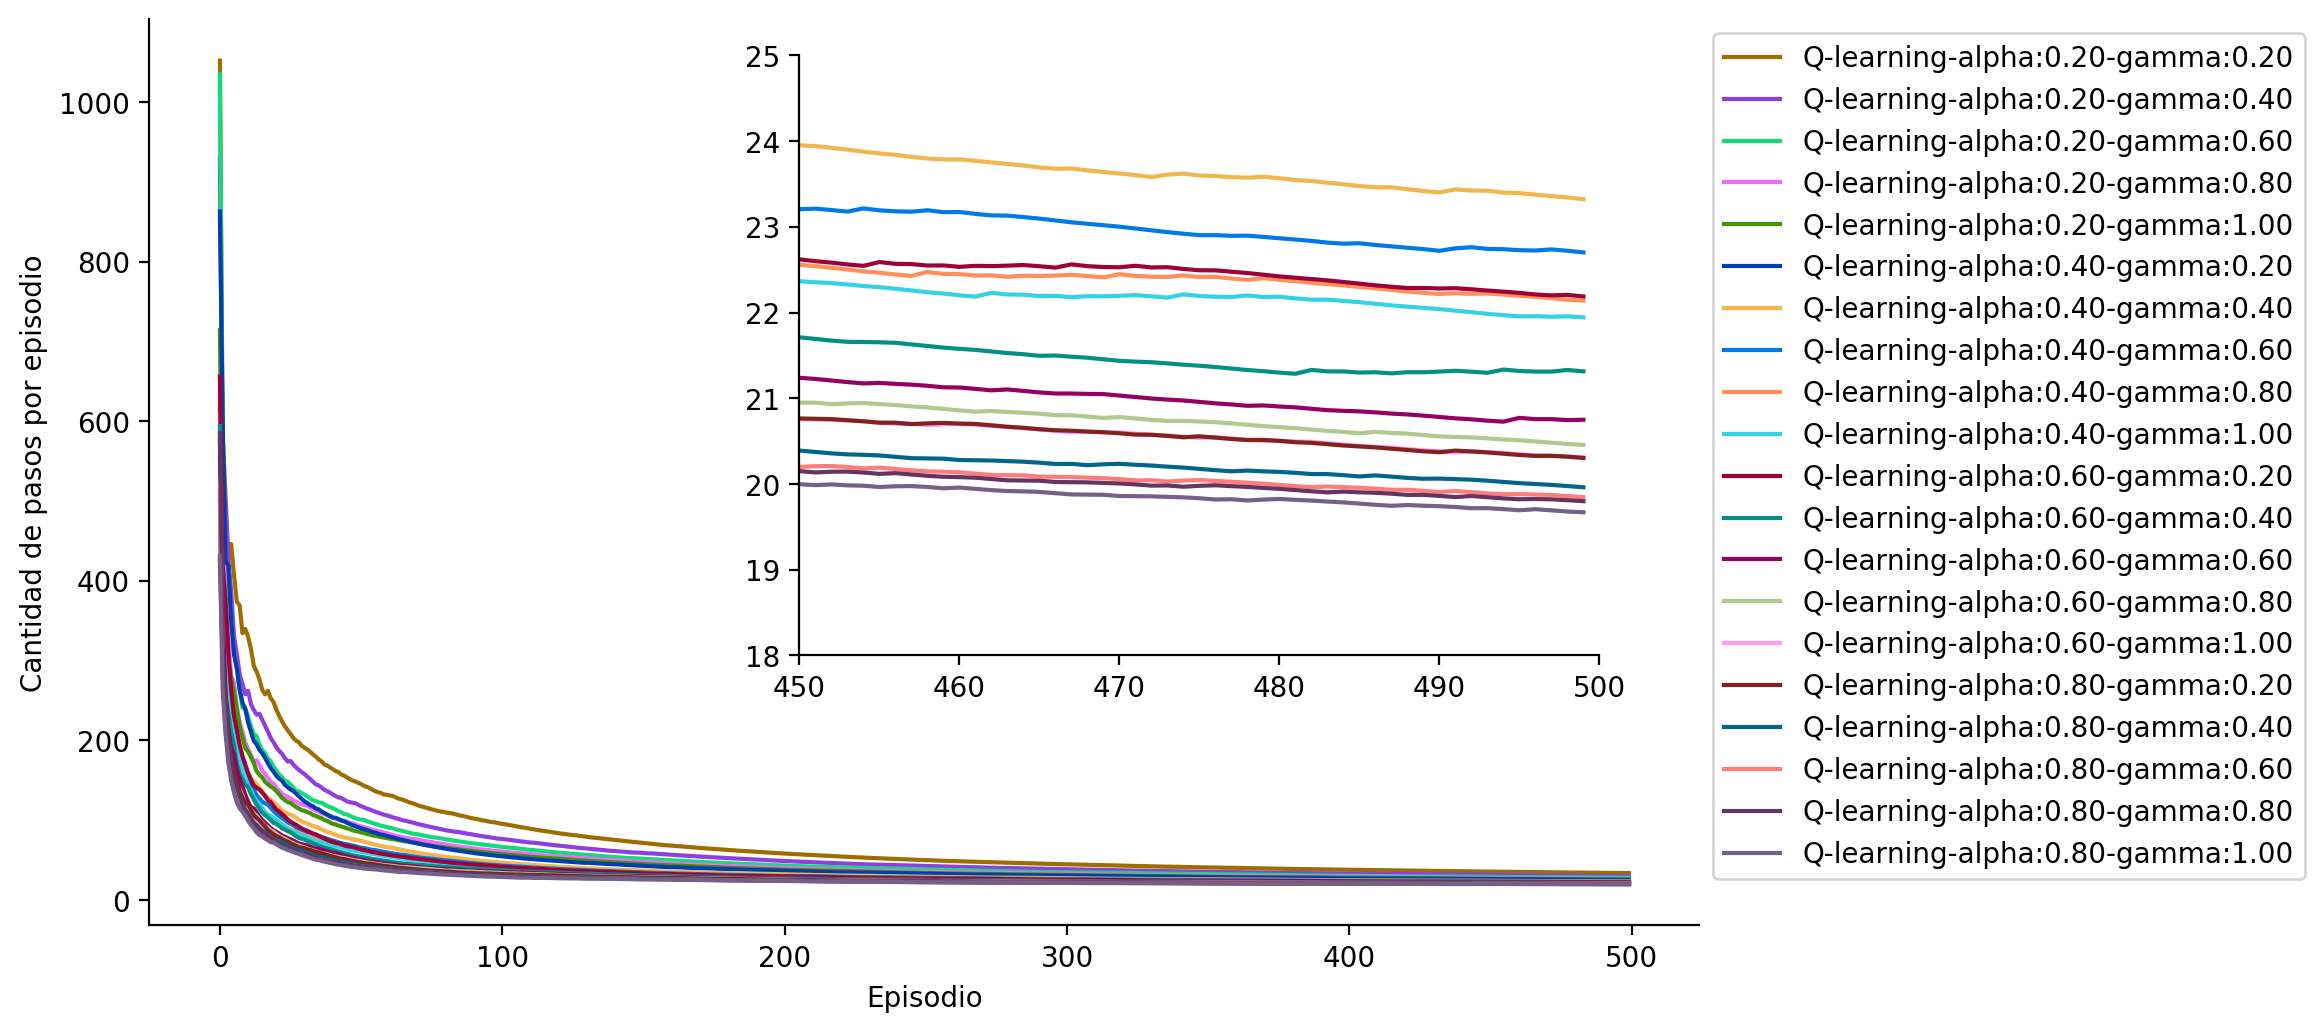

In [15]:
plt.figure(figsize=(10,6), dpi=200)
ax1 = plt.axes()  # standard axes
ax2 = plt.axes([0.45, 0.35, 0.4, 0.5])
df = pd.DataFrame(q_timesteps)
s = sns.lineplot(ax=ax1, data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors)
sns.despine()
s.legend(bbox_to_anchor=(1.0, 1))
s.set_ylabel("Cantidad de pasos por episodio")
s.set_xlabel("Episodio")
s2 = sns.lineplot(ax=ax2, data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette=colors,legend=False)
s2.set_xlim(450,500)
s2.set_ylim(18,25)

En lineas generales se observa que el aprendizaje de Q-learning es mas homogéneo. El hecho de que Q-learning es un algoritmo off-policy ayuda a la convergencia de la función `q` ya que no se tienen en cuenta las acciones aleatorias. Valores altos de `gamma` aumentan ligeramente el desempeño, tanto en términos de la recompensa acumulada como en la cantidad de pasos. En el corto plazo, un `alpha` mas grande ayuda a una convergencia mas veloz, sin desestabilizarla en el largo plazo.

En función de lo dicho, escojemos los siguientes hiperparámetros:

- `alpha` = 0.8
- `gamma` = 1.0

# SARSA vs Q-learning

Una vez establecidos los valores para `alpha` y `gamma`, exploramos el impacto de `epsilon` y comparamos las soluciones obtenidas por ambos algoritmos.

In [16]:
s_alpha = 0.5
gamma = 1.0
q_alpha = 0.8

In [19]:
timesteps = {}
rewards = {} 
q = {}

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
episodes_to_run = 500
epsilon = 0.1

for epsilon in [0.0, 0.05, 0.1, 0.2]:
    q_qlearning_i = {}
    random_state = np.random.RandomState(42)
    timesteps_i, reward_i = q_learning(q_qlearning_i, q_alpha, gamma, epsilon, episodes_to_run)

    name = "Q-learning-alpha:%.2f-gamma:%.2f-epsilon:%.2f" % (q_alpha, gamma, epsilon)
    timesteps[name] = timesteps_i
    rewards[name] = reward_i
    q[name] = q_qlearning_i

    q_sarsa_i = {}
    random_state = np.random.RandomState(42)
    timesteps_i, reward_i = sarsa_learning(q_sarsa_i, s_alpha, gamma, epsilon, episodes_to_run)

    name = "SARSA-alpha:%.2f-gamma:%.2f-epsilon:%.2f" % (s_alpha, gamma, epsilon)
    timesteps[name] = timesteps_i
    rewards[name] = reward_i
    q[name] = q_sarsa_i
env.close()

Text(0.5, 0, 'Episodio')

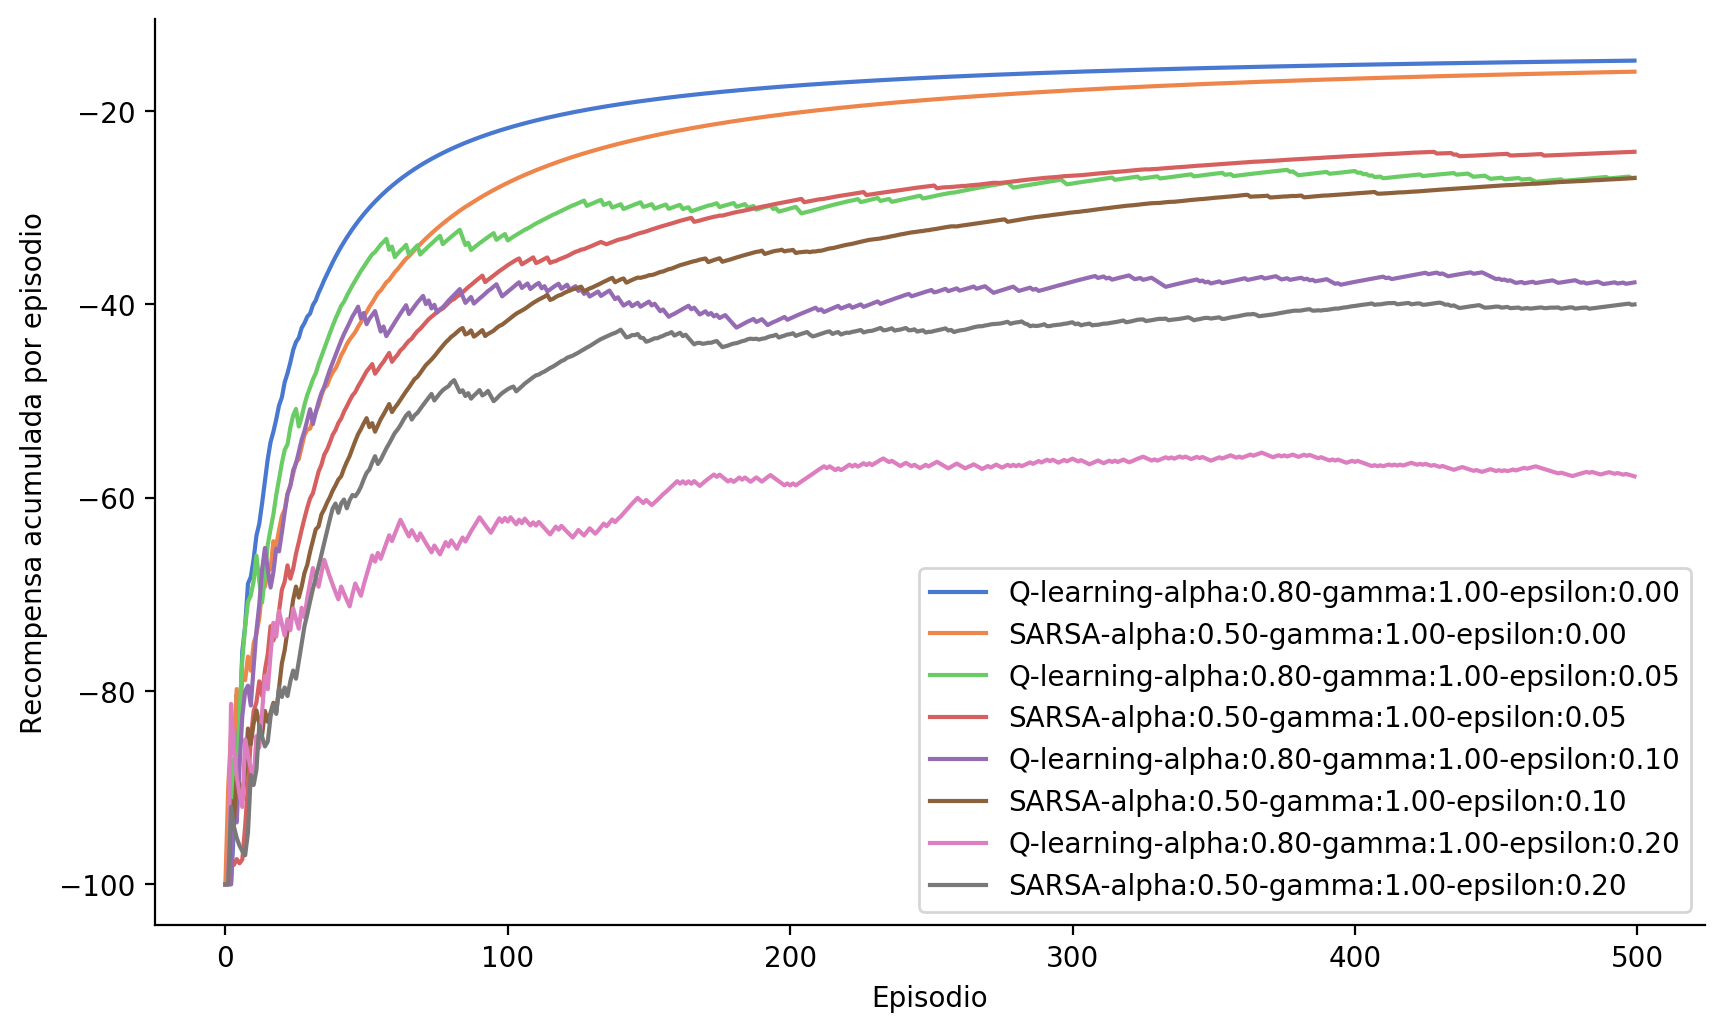

In [20]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(rewards)
sns.lineplot(data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette="muted")
sns.despine()

plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")

Text(0.5, 0, 'Episodio')

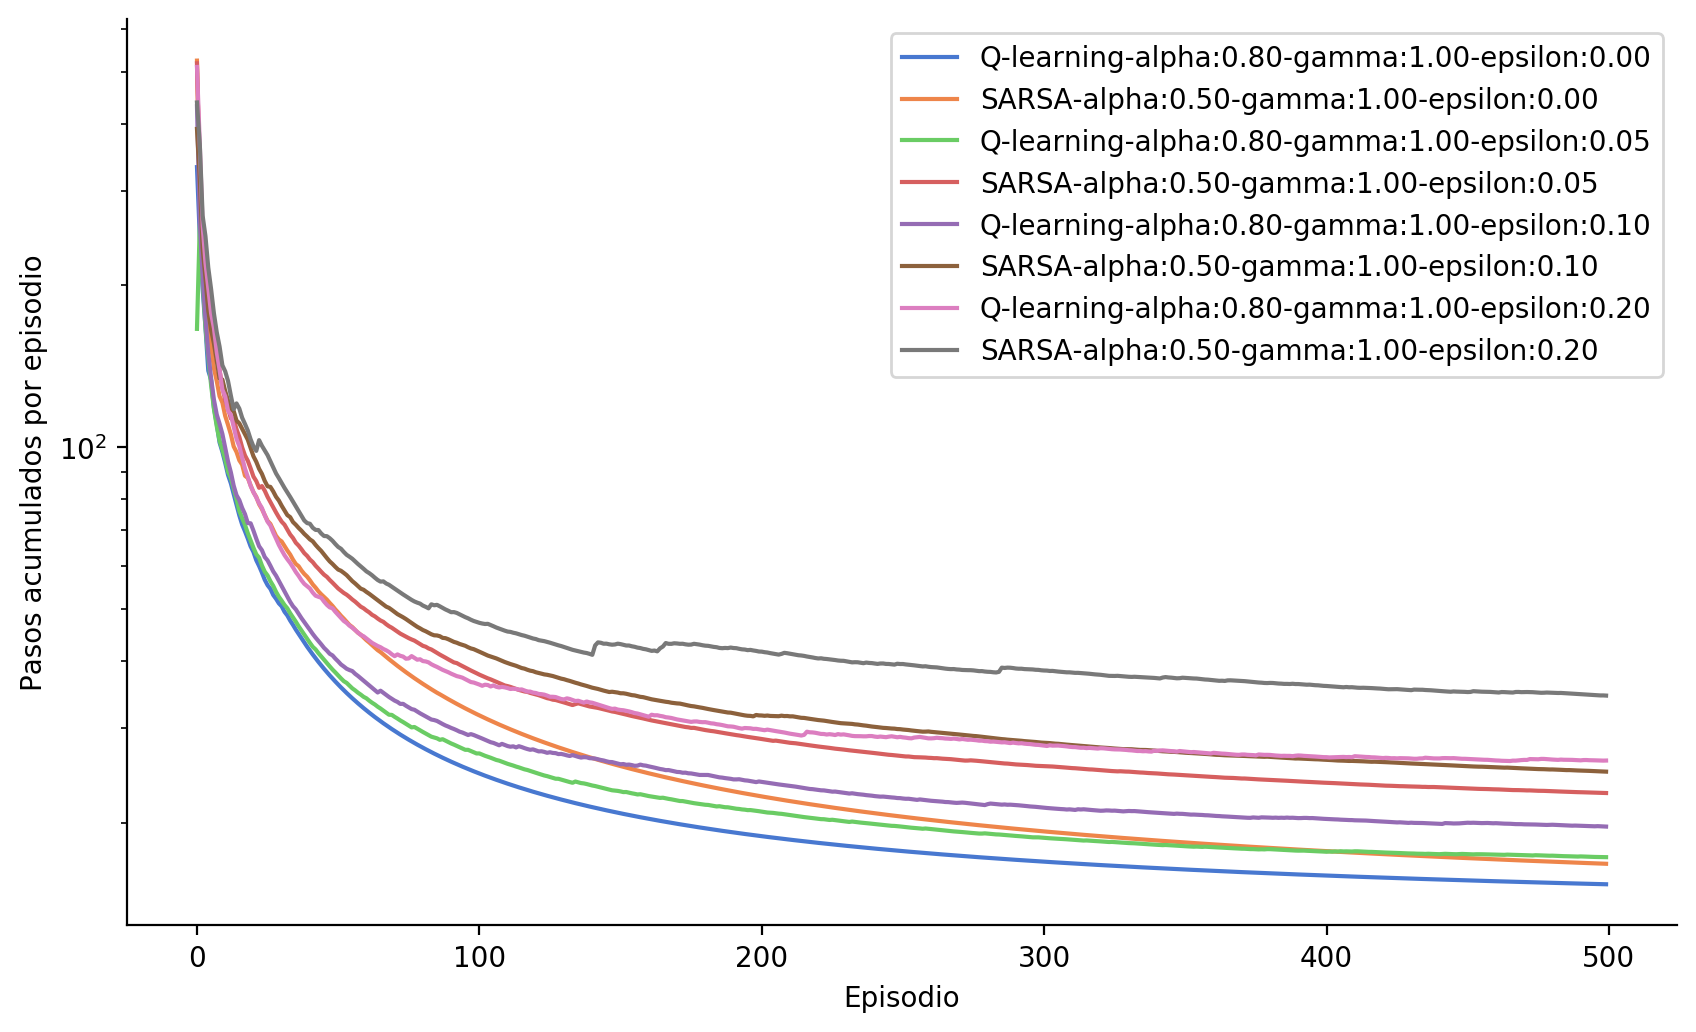

In [21]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(timesteps)
sns.lineplot(data=df.rolling(episodes_to_run, min_periods=1).mean(), dashes=False, palette="muted")
sns.despine()
plt.yscale("log")
plt.ylabel("Pasos acumulados por episodio")
plt.xlabel("Episodio")

Como primera consideración general podemos decir que el valor de `epsilon` no es determinante para la convergencia. Ninguno de los dos algorimtos saca mayor provecho de la posibilidad de encontrar mejores acciones por comportarse de forma aleatoria. Esto tiene que ver principalmente por el hecho de que la función `q` está inicializada en 0, y las recompensas (acumuladas) son negativas. Un efecto directo es que en la fase inicial de aprendizaje la mejor acción a seleccionar es alguna que aun no se ha explorado. Como consecuencia, hacia el inicio del aprendizaje se realiza una exploración no deterministica de un buen numero de caminos. Esto parece ser suficiente para encontrar caminos hacia el objetivo, que luego son reforzados de manera inversamente proporcional a `epsilon`, considerando además que a medida que el valor de `epsilon` aumenta, se vuelve mas probable que el agente caiga en el acantilado.

Consideremos ahora los valores no nulos de `epsilon`. Q-learning se ve mas afectado que SARSA, cuanto mayor es el valor de `epsilon`. Esto se debe a que SARSA converge hacia una solución mas `conservadora`, haciendo que el agente se aleje del acantilado. El gráfico de pasos acumulados sostiene este hecho, mostrando mejor desempeño de Q-learning frente a SARSA. Dicho de otra forma, los caminos que recorre el agente de SARSA son mas largos. Esto puede verse además en la matriz de solución "SARSA-alpha:0.50-gamma:1.00-epsilon:0.05":

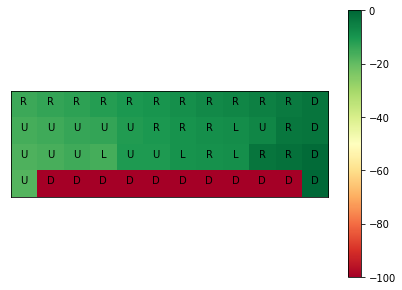


 Matriz de mejor acción-valor (en números): 

 [[ -14.83357518  -13.62069625  -12.51476491  -11.45712195  -10.43061728
    -9.4450847    -8.44312991   -7.41464002   -6.37189639   -5.27421055
    -4.13627994   -3.03887138]
 [ -15.99848052  -14.84934884  -13.7747012   -13.43841937  -11.16759673
   -10.35893055   -9.32639788   -8.29174396   -7.86242408   -6.41422156
    -3.50323094   -2.93125962]
 [ -16.97479558  -16.11255245  -15.20474198  -15.66740832  -10.75752947
   -10.55561621   -9.08826196   -8.73026421   -8.26473788   -3.
    -2.           -1.        ]
 [ -17.96496669 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.            0.        ]]


In [23]:
draw_value_matrix(q["SARSA-alpha:0.50-gamma:1.00-epsilon:0.05"])

Para entender por qué ocurre esto, supongamos que estamos en el medio del ciclo de entrenamiento de SARSA, y nos encontramos en una posición `s` al borde del acantilado. Supongamos ademas que la acción actual `action` es "ir hacia la derecha", y que por efecto de `epsilon` la proxima acción, `next_action`, es ir hacia abajo. El paso de actualización hace que `q(s, action)` tome el valor

`q(s, action) + 0.5 * (-1 + 1.0 * q(s', next_action) - q(s, action))`

y `q(s', next_action)` es -100. Esto desalienta al agente de moverse por la cornisa, dando un valor muy negativo a la `action`.

Por el contrario, como Q-learning es off-policy, la función `q` no se ve afectada por la poco probable posibilidad de que el agente escoga de modo aleatorio caer en el acantilado. Esto queda plasmado en cualquier de las soluciones obtenidas. La solución es "óptima" en el sentido que minimiza la longitud de los caminos para llegar al objetivo. 

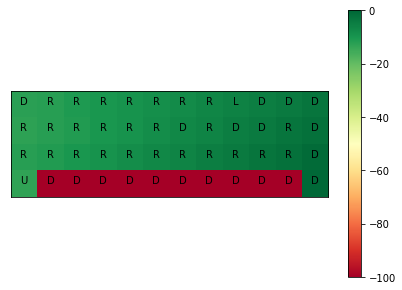


 Matriz de mejor acción-valor (en números): 

 [[ -12.31515869  -11.80840816  -10.86946529  -10.06701095   -9.14751499
    -8.2871738    -7.51196897   -6.59041548   -5.70962944   -4.88433874
    -3.99128739   -2.99983858]
 [ -12.88360069  -11.99141848  -10.99897546   -9.99980603   -8.99990882
    -7.99997132   -6.99999678   -5.99999965   -4.99999997   -4.
    -3.           -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.            0.        ]]


In [24]:
draw_value_matrix(q["Q-learning-alpha:0.80-gamma:1.00-epsilon:0.05"])

Si consideramos `gamma` igual a 0, la politica ejecutada por SARSA coincide con la politica entrenada (se pierde la diferencia entre on/off-policy). Así SARSA obtiene una solución "arriesgada" como la de Q-learning con un desempeño similar:

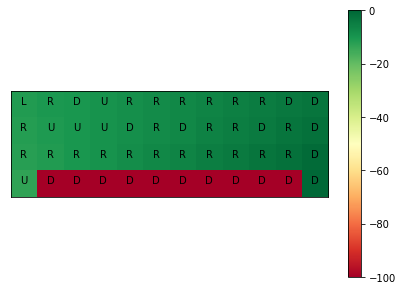


 Matriz de mejor acción-valor (en números): 

 [[ -10.96419998  -10.45327542   -9.89710791   -9.06632152   -8.44980971
    -7.71116702   -6.87442704   -6.02656567   -5.31375343   -4.50154686
    -3.73167035   -2.95054457]
 [ -11.38251732  -10.74695339   -9.91718417   -9.13952819   -8.41807392
    -7.56693169   -6.65475559   -5.77350395   -4.87343488   -3.92696983
    -2.97922036   -1.99976658]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.            0.        ]]


In [25]:
draw_value_matrix(q["SARSA-alpha:0.50-gamma:1.00-epsilon:0.00"])